# Tensor Flow Notebook
## W207 Final Project
### T. P. Goter
### July 15, 2019

This workbook is used to create convolutional neural nets for facial keypoint detection on CPUs (not TPUs).

In [1]:
# Import needed packages
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras import optimizers, metrics
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
tf.__version__
tf.keras.backend.clear_session()

## Data Loading

- Load in the pickle file that was created as part of the EDA in DataExploration.ipynb. 
- This dataset has the NaNs removed and a few mislabeled images removed as well. 
- As such there is only limited training and development data to use. 
- The image data has already been normalized to [0,1]

In [3]:
# Initialize Random Seed for reproducibility
np.random.seed(13)

# Load the dataframe from the pickle file
df_nostache_nonan = pd.read_pickle("df_nostache_nonan.pkl")

# Grab the last column - that is our image data for X matrix
X = df_nostache_nonan.iloc[:, -1]

# Convert from a series of arrays to an NDarray
X = np.array([x.reshape(96,96,1) for x in X])

# Grab the keypoints and stick into our y-variable
y = np.array(df_nostache_nonan.iloc[:,:-1])
# y = (y - 48) / 48  # scale target coordinates to [-1, 1]

In [4]:
X.shape

(2140, 96, 96, 1)

## Baseline Neural Net
CNNs are combinations of convolution layers, pooling layers and dropout layers followed by one or two fully connected layers once the number of dimensions has been sufficiently reduced.

1. Let's include just one hidden layer and one output layer
2. The input layer will reduce our flattened 96x96 matrix (i.e., 9216 in length) to a predetermined number of hidden units
3. We will then run sensitivities to # of hidden units, activation, optimizer, and learning rate
4. We will judge our model based on RMSE error and run time.

In [5]:
def create_cnn_model():
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(64, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
  
    return cnn_model
   
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [6]:
def create_bad_cnn_model():
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(64, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('relu'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
  
    return cnn_model

#### Define our optimizers for our initial study

In [12]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
sgd = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

opt_list = {'adam':adam,'sgd':sgd, 'nadam':nadam, 'adagrad':adagrad}
#opt_list = {'adam':adam}

#### Set up our first DOE

In [ ]:
time_callback = TimeHistory()
cnn_base_df = pd.DataFrame()
for opt_name, opt in opt_list.items():
    model = create_cnn_model()
    model.compile(
          optimizer=opt_list['adam'],
          loss='mean_squared_error',
          metrics=['mean_squared_error'])
    history = model.fit(
        X.astype(np.float32), y.astype(np.float32),
        epochs=200,
        validation_split=0.15, callbacks=[time_callback])
    times = time_callback.times
    
    # Convert to dataframe
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist['RMSE'] = np.sqrt(hist.mean_squared_error)
    hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
    hist['times'] = times
    hist['layers'] = 3
    hist['pooling'] = 'yes'
    hist['fc_layer'] = 500
    hist['activation'] = 'relu'
    hist['optimizer'] = opt_name
    hist['lrate'] = opt.get_config()['learning_rate']
    
    # Keep concatenating to dataframe
    cnn_base_df = pd.concat([cnn_base_df,hist])

    # Re-pickle after every model to retain progress
    cnn_base_df.to_pickle("OutputData/cnn_base_df.pkl")

    # Save models.
    filename = "cnn_model_{}".format( opt_name)
    model.save("Models/"+filename+".h5")
    

# Run with RELU output activation to show issue

In [10]:
time_callback = TimeHistory()
cnn_relu_df = pd.DataFrame()
for opt_name, opt in opt_list.items():
    model = create_bad_cnn_model()
    model.compile(
          optimizer=opt_list['adam'],
          loss='mean_squared_error',
          metrics=['mean_squared_error'])
    history = model.fit(
        X.astype(np.float32), y.astype(np.float32),
        epochs=200,
        validation_split=0.15, callbacks=[time_callback])
    times = time_callback.times
    
    # Convert to dataframe
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist['RMSE'] = np.sqrt(hist.mean_squared_error)
    hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
    hist['times'] = times
    hist['layers'] = 3
    hist['pooling'] = 'yes'
    hist['fc_layer'] = 500
    hist['activation'] = 'relu'
    hist['optimizer'] = opt_name
    hist['lrate'] = opt.get_config()['learning_rate']
    
    # Keep concatenating to dataframe
    cnn_relu_df = pd.concat([cnn_relu_df,hist])

    # Re-pickle after every model to retain progress
    cnn_relu_df.to_pickle("OutputData/cnn_relu_df.pkl")

    # Save models.
    filename = "bad_cnn_model_{}".format( opt_name)
    model.save("Models/"+filename+".h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0

Epoch 35/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.5777 - mean_squared_error: 575.5776 - val_loss: 574.2953 - val_mean_squared_error: 574.2953
Epoch 36/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.6989 - mean_squared_error: 575.6989 - val_loss: 574.2664 - val_mean_squared_error: 574.2664
Epoch 37/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.5464 - mean_squared_error: 575.5464 - val_loss: 574.8460 - val_mean_squared_error: 574.8460
Epoch 38/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.6901 - mean_squared_error: 575.6901 - val_loss: 574.2470 - val_mean_squared_error: 574.2469
Epoch 39/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.6243 - mean_squared_error: 575.6243 - val_loss: 574.6216 - val_mean_squared_error: 574.6215
Epoch 40/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 575.3692 - mean_squared_error: 575

1819/1819 [==============================] - 10s 5ms/sample - loss: 574.9220 - mean_squared_error: 574.9220 - val_loss: 573.9140 - val_mean_squared_error: 573.9140
Epoch 82/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 574.3111 - mean_squared_error: 574.3110 - val_loss: 573.7217 - val_mean_squared_error: 573.7217
Epoch 83/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 574.2437 - mean_squared_error: 574.2437 - val_loss: 573.7361 - val_mean_squared_error: 573.7361
Epoch 84/200
1819/1819 [==============================] - 10s 5ms/sample - loss: 574.3328 - mean_squared_error: 574.3328 - val_loss: 573.8613 - val_mean_squared_error: 573.8613
Epoch 85/200
1819/1819 [==============================] - 10s 5ms/sample - loss: 574.2774 - mean_squared_error: 574.2773 - val_loss: 573.9860 - val_mean_squared_error: 573.9860
Epoch 86/200
1819/1819 [==============================] - 10s 5ms/sample - loss: 574.2960 - mean_squared_error: 574.2960 - val_l

1819/1819 [==============================] - 10s 5ms/sample - loss: 573.9944 - mean_squared_error: 573.9945 - val_loss: 573.8156 - val_mean_squared_error: 573.8156
Epoch 128/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 573.9754 - mean_squared_error: 573.9754 - val_loss: 573.8170 - val_mean_squared_error: 573.8170
Epoch 129/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 573.9351 - mean_squared_error: 573.9350 - val_loss: 573.7995 - val_mean_squared_error: 573.7995
Epoch 130/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 573.9019 - mean_squared_error: 573.9019 - val_loss: 573.8474 - val_mean_squared_error: 573.8474
Epoch 131/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 574.0116 - mean_squared_error: 574.0117 - val_loss: 573.8295 - val_mean_squared_error: 573.8295
Epoch 132/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 573.9431 - mean_squared_error: 573.9429 - 

1819/1819 [==============================] - 10s 6ms/sample - loss: 573.9108 - mean_squared_error: 573.9108 - val_loss: 573.8758 - val_mean_squared_error: 573.8759
Epoch 174/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 573.8455 - mean_squared_error: 573.8455 - val_loss: 573.8071 - val_mean_squared_error: 573.8071
Epoch 175/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 573.8573 - mean_squared_error: 573.8573 - val_loss: 573.8284 - val_mean_squared_error: 573.8284
Epoch 176/200
1819/1819 [==============================] - 10s 5ms/sample - loss: 573.8751 - mean_squared_error: 573.8751 - val_loss: 573.8465 - val_mean_squared_error: 573.8465
Epoch 177/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 573.8449 - mean_squared_error: 573.8448 - val_loss: 573.9102 - val_mean_squared_error: 573.9102
Epoch 178/200
1819/1819 [==============================] - 10s 6ms/sample - loss: 574.0977 - mean_squared_error: 574.0977 - 

In [26]:
predictions = model.predict(X[-5:])

In [27]:
predictions.shape

(5, 30)

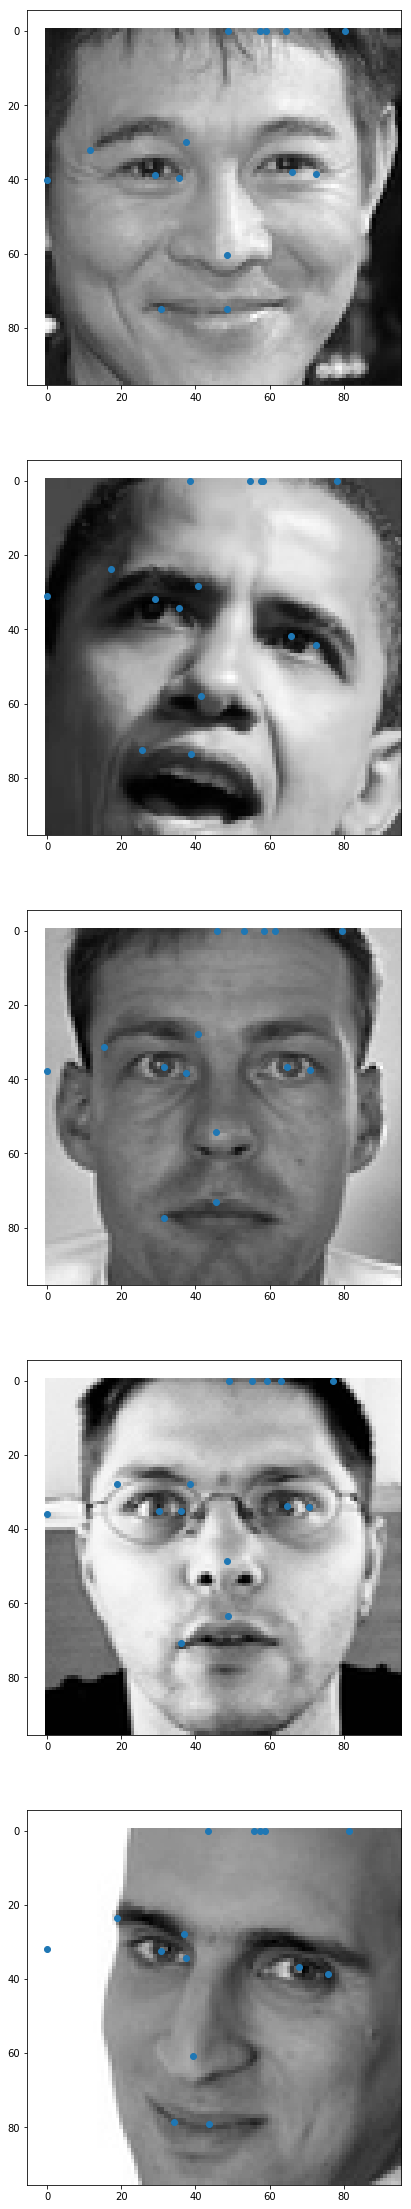

In [28]:
fig, axes = plt.subplots(len(predictions), 1, figsize=(8,8*len(predictions)))
axes = axes.flatten()
xs = predictions[:,0:30:2]
ys = predictions[:,1:30:2]
for i, ax in enumerate(axes):
    ax.imshow(np.reshape(X[-5+i],(96,96)), origin='upper', cmap='gray')
    ax.scatter(x=xs[i,:], y=ys[i,:])


In [32]:
def create_filter_cnn_model(start_filters=32):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filters, (3, 3), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filters*2, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filters*4, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
  
    return cnn_model

In [33]:
# Redefine optimizer list to just focus on adam and sgd
opt_list = {'adam':adam,'sgd':sgd}

# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_filter_df = pd.DataFrame()

# Let's try a range of starting filter sizes from 3 to 16 (our baseline had 32)
n_filters = [3, 5, 12, 16]
for n in n_filters:
    for opt_name, opt in opt_list.items():
        model = create_filter_cnn_model(start_filters=n)
        model.compile(
              optimizer=opt,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
        history = model.fit(
            X.astype(np.float32), y.astype(np.float32),
            epochs=200,
            validation_split=0.15, callbacks=[time_callback, early_stop])
        times = time_callback.times

        # Convert to dataframe
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch
        hist['RMSE'] = np.sqrt(hist.mean_squared_error)
        hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
        hist['times'] = times
        hist['starting_filter'] = n
        hist['layers'] = 3
        hist['pooling'] = 'yes'
        hist['fc_layer'] = 500
        hist['activation'] = 'relu'
        hist['optimizer'] = opt_name
        hist['lrate'] = opt.get_config()['learning_rate']

        # Keep concatenating to dataframe
        cnn_filter_df = pd.concat([cnn_filter_df,hist])

        # Re-pickle after every model to retain progress
        cnn_filter_df.to_pickle("OutputData/cnn_filter_df.pkl")

        # Save models.
        filename = "filter_cnn_model_{}_{}filters".format(opt_name, n)
        model.save("Models/"+filename+".h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 94, 94, 3)         30        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 47, 47, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 6)         78        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 22, 22, 12)        300       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 11, 11, 12)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1452)             

1819/1819 [==============================] - 2s 1ms/sample - loss: 6.0632 - mean_squared_error: 6.0632 - val_loss: 6.2737 - val_mean_squared_error: 6.2737
Epoch 37/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 6.0540 - mean_squared_error: 6.0540 - val_loss: 6.7862 - val_mean_squared_error: 6.7862
Epoch 38/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 6.0144 - mean_squared_error: 6.0144 - val_loss: 5.9547 - val_mean_squared_error: 5.9547
Epoch 39/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 5.8032 - mean_squared_error: 5.8032 - val_loss: 5.8672 - val_mean_squared_error: 5.8672
Epoch 40/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 5.6799 - mean_squared_error: 5.6799 - val_loss: 5.7687 - val_mean_squared_error: 5.7687
Epoch 41/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 5.5644 - mean_squared_error: 5.5644 - val_loss: 5.7267 - val_mean_squared_error: 5.7267
Epoch

Epoch 85/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.4876 - mean_squared_error: 2.4876 - val_loss: 3.5072 - val_mean_squared_error: 3.5072
Epoch 86/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.4113 - mean_squared_error: 2.4113 - val_loss: 3.7545 - val_mean_squared_error: 3.7545
Epoch 87/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.3089 - mean_squared_error: 2.3089 - val_loss: 3.3849 - val_mean_squared_error: 3.3849
Epoch 88/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.4857 - mean_squared_error: 2.4857 - val_loss: 3.5103 - val_mean_squared_error: 3.5103
Epoch 89/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.3594 - mean_squared_error: 2.3594 - val_loss: 3.3016 - val_mean_squared_error: 3.3016
Epoch 90/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 2.2927 - mean_squared_error: 2.2927 - val_loss: 3.5252 - val_mean_squared_error:

1819/1819 [==============================] - 2s 1ms/sample - loss: 1.3814 - mean_squared_error: 1.3814 - val_loss: 3.1328 - val_mean_squared_error: 3.1328
Epoch 134/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 1.4055 - mean_squared_error: 1.4055 - val_loss: 3.0882 - val_mean_squared_error: 3.0882
Epoch 135/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 1.3848 - mean_squared_error: 1.3848 - val_loss: 3.2347 - val_mean_squared_error: 3.2347
Epoch 136/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 1.5267 - mean_squared_error: 1.5267 - val_loss: 3.0914 - val_mean_squared_error: 3.0914
Epoch 137/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 1.5202 - mean_squared_error: 1.5202 - val_loss: 3.0547 - val_mean_squared_error: 3.0547
Epoch 138/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 1.4053 - mean_squared_error: 1.4053 - val_loss: 3.2465 - val_mean_squared_error: 3.2465


1819/1819 [==============================] - 2s 1ms/sample - loss: 0.8882 - mean_squared_error: 0.8882 - val_loss: 3.0707 - val_mean_squared_error: 3.0707
Epoch 182/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 0.8087 - mean_squared_error: 0.8087 - val_loss: 3.0416 - val_mean_squared_error: 3.0416
Epoch 183/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 0.7892 - mean_squared_error: 0.7892 - val_loss: 3.2756 - val_mean_squared_error: 3.2756
Epoch 184/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 0.8630 - mean_squared_error: 0.8630 - val_loss: 3.0708 - val_mean_squared_error: 3.0708
Epoch 185/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 0.7692 - mean_squared_error: 0.7692 - val_loss: 3.0278 - val_mean_squared_error: 3.0278
Epoch 186/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 0.7665 - mean_squared_error: 0.7665 - val_loss: 3.1422 - val_mean_squared_error: 3.1422


Epoch 15/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 1050.9138 - mean_squared_error: 1050.9138 - val_loss: 677.7497 - val_mean_squared_error: 677.7498
Epoch 16/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 473.3040 - mean_squared_error: 473.3041 - val_loss: 306.5498 - val_mean_squared_error: 306.5498
Epoch 17/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 216.2328 - mean_squared_error: 216.2328 - val_loss: 141.6104 - val_mean_squared_error: 141.6104
Epoch 18/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 101.8305 - mean_squared_error: 101.8305 - val_loss: 68.3015 - val_mean_squared_error: 68.3015
Epoch 19/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 50.9596 - mean_squared_error: 50.9596 - val_loss: 35.6806 - val_mean_squared_error: 35.6806
Epoch 20/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 28.3154 - mean_squared_error: 28.3154 - val_

Epoch 63/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1895 - mean_squared_error: 10.1895 - val_loss: 9.8837 - val_mean_squared_error: 9.8837
Epoch 64/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1891 - mean_squared_error: 10.1891 - val_loss: 9.8841 - val_mean_squared_error: 9.8841
Epoch 65/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1890 - mean_squared_error: 10.1890 - val_loss: 9.8840 - val_mean_squared_error: 9.8840
Epoch 66/200
1819/1819 [==============================] - 3s 1ms/sample - loss: 10.1893 - mean_squared_error: 10.1893 - val_loss: 9.8829 - val_mean_squared_error: 9.8829
Epoch 67/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1892 - mean_squared_error: 10.1892 - val_loss: 9.8839 - val_mean_squared_error: 9.8839
Epoch 68/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1890 - mean_squared_error: 10.1890 - val_loss: 9.8845 - val_mean_sq

1819/1819 [==============================] - 3s 1ms/sample - loss: 10.1890 - mean_squared_error: 10.1890 - val_loss: 9.8837 - val_mean_squared_error: 9.8837
Epoch 112/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1889 - mean_squared_error: 10.1889 - val_loss: 9.8842 - val_mean_squared_error: 9.8842
Epoch 113/200
1819/1819 [==============================] - 2s 1ms/sample - loss: 10.1893 - mean_squared_error: 10.1893 - val_loss: 9.8833 - val_mean_squared_error: 9.8833
Epoch 114/200
1819/1819 [==============================] - 3s 1ms/sample - loss: 10.1892 - mean_squared_error: 10.1892 - val_loss: 9.8833 - val_mean_squared_error: 9.8833
Epoch 115/200
1819/1819 [==============================] - 3s 1ms/sample - loss: 10.1888 - mean_squared_error: 10.1888 - val_loss: 9.8838 - val_mean_squared_error: 9.8838
Epoch 116/200
1819/1819 [==============================] - 3s 1ms/sample - loss: 10.1891 - mean_squared_error: 10.1891 - val_loss: 9.8841 - val_mean_squared_er

1819/1819 [==============================] - 3s 2ms/sample - loss: 8.9140 - mean_squared_error: 8.9140 - val_loss: 8.7684 - val_mean_squared_error: 8.7684
Epoch 20/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 8.7044 - mean_squared_error: 8.7044 - val_loss: 8.9578 - val_mean_squared_error: 8.9578
Epoch 21/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 8.5022 - mean_squared_error: 8.5022 - val_loss: 8.5452 - val_mean_squared_error: 8.5452
Epoch 22/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 8.4160 - mean_squared_error: 8.4160 - val_loss: 8.5869 - val_mean_squared_error: 8.5869
Epoch 23/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 8.3058 - mean_squared_error: 8.3058 - val_loss: 8.1946 - val_mean_squared_error: 8.1946
Epoch 24/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 8.0228 - mean_squared_error: 8.0228 - val_loss: 8.4364 - val_mean_squared_error: 8.4364
Epoch

Epoch 68/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.8082 - mean_squared_error: 3.8082 - val_loss: 4.3932 - val_mean_squared_error: 4.3932
Epoch 69/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.8425 - mean_squared_error: 3.8425 - val_loss: 4.2441 - val_mean_squared_error: 4.2441
Epoch 70/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.6345 - mean_squared_error: 3.6345 - val_loss: 4.8376 - val_mean_squared_error: 4.8376
Epoch 71/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.7103 - mean_squared_error: 3.7103 - val_loss: 4.9922 - val_mean_squared_error: 4.9922
Epoch 72/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.6714 - mean_squared_error: 3.6714 - val_loss: 4.1341 - val_mean_squared_error: 4.1341
Epoch 73/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 3.5675 - mean_squared_error: 3.5675 - val_loss: 4.0222 - val_mean_squared_error:

Epoch 117/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.2437 - mean_squared_error: 2.2437 - val_loss: 3.4887 - val_mean_squared_error: 3.4887
Epoch 118/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.2471 - mean_squared_error: 2.2471 - val_loss: 3.4721 - val_mean_squared_error: 3.4721
Epoch 119/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.2592 - mean_squared_error: 2.2592 - val_loss: 3.2886 - val_mean_squared_error: 3.2886
Epoch 120/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.2032 - mean_squared_error: 2.2032 - val_loss: 3.1801 - val_mean_squared_error: 3.1801
Epoch 121/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.1056 - mean_squared_error: 2.1056 - val_loss: 3.2476 - val_mean_squared_error: 3.2476
Epoch 122/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 2.0628 - mean_squared_error: 2.0628 - val_loss: 3.1301 - val_mean_squared_

1819/1819 [==============================] - 4s 2ms/sample - loss: 1.4032 - mean_squared_error: 1.4032 - val_loss: 3.1899 - val_mean_squared_error: 3.1899
Epoch 166/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 1.3323 - mean_squared_error: 1.3323 - val_loss: 3.0060 - val_mean_squared_error: 3.0060
Epoch 167/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 1.3365 - mean_squared_error: 1.3365 - val_loss: 3.0077 - val_mean_squared_error: 3.0077
Epoch 168/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 1.3057 - mean_squared_error: 1.3057 - val_loss: 3.0532 - val_mean_squared_error: 3.0532
Epoch 169/200
1819/1819 [==============================] - 3s 2ms/sample - loss: 1.3339 - mean_squared_error: 1.3339 - val_loss: 3.0125 - val_mean_squared_error: 3.0125
Epoch 170/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 1.3181 - mean_squared_error: 1.3181 - val_loss: 2.8841 - val_mean_squared_error: 2.8841


Train on 1819 samples, validate on 321 samples
Epoch 1/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 2/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 3/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 4/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 5/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 6/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 7/200
1819/1819 [

1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 54/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 55/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 56/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 57/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 58/200
1819/1819 [==============================] - 3s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 59/200
1819/1819 [==============================] - 3s 2ms/sample - los

Train on 1819 samples, validate on 321 samples
Epoch 1/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 752.3760 - mean_squared_error: 752.3762 - val_loss: 45.3117 - val_mean_squared_error: 45.3117
Epoch 2/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 18.7290 - mean_squared_error: 18.7290 - val_loss: 10.9340 - val_mean_squared_error: 10.9340
Epoch 3/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.8785 - mean_squared_error: 10.8785 - val_loss: 10.4603 - val_mean_squared_error: 10.4603
Epoch 4/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.6031 - mean_squared_error: 10.6031 - val_loss: 10.6460 - val_mean_squared_error: 10.6460
Epoch 5/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.4931 - mean_squared_error: 10.4931 - val_loss: 10.1670 - val_mean_squared_error: 10.1670
Epoch 6/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.4340 - mean_sq

1819/1819 [==============================] - 6s 3ms/sample - loss: 7.8840 - mean_squared_error: 7.8840 - val_loss: 7.8904 - val_mean_squared_error: 7.8904
Epoch 50/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.8295 - mean_squared_error: 7.8295 - val_loss: 7.7456 - val_mean_squared_error: 7.7456
Epoch 51/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.6741 - mean_squared_error: 7.6741 - val_loss: 7.6860 - val_mean_squared_error: 7.6860
Epoch 52/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.5684 - mean_squared_error: 7.5684 - val_loss: 7.5518 - val_mean_squared_error: 7.5518
Epoch 53/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.5160 - mean_squared_error: 7.5160 - val_loss: 7.7653 - val_mean_squared_error: 7.7653
Epoch 54/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.6505 - mean_squared_error: 7.6505 - val_loss: 8.0495 - val_mean_squared_error: 8.0495
Epoch

Epoch 98/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 2.6083 - mean_squared_error: 2.6083 - val_loss: 3.5914 - val_mean_squared_error: 3.5914
Epoch 99/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 2.6152 - mean_squared_error: 2.6152 - val_loss: 3.5208 - val_mean_squared_error: 3.5208
Epoch 100/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 2.7582 - mean_squared_error: 2.7582 - val_loss: 3.5536 - val_mean_squared_error: 3.5536
Epoch 101/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 2.5843 - mean_squared_error: 2.5843 - val_loss: 3.2613 - val_mean_squared_error: 3.2613
Epoch 102/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 2.4608 - mean_squared_error: 2.4608 - val_loss: 4.2795 - val_mean_squared_error: 4.2795
Epoch 103/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 2.4818 - mean_squared_error: 2.4818 - val_loss: 3.2578 - val_mean_squared_er

1819/1819 [==============================] - 4s 2ms/sample - loss: 1.1927 - mean_squared_error: 1.1927 - val_loss: 2.7483 - val_mean_squared_error: 2.7483
Epoch 147/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 1.1946 - mean_squared_error: 1.1946 - val_loss: 2.7192 - val_mean_squared_error: 2.7192
Epoch 148/200
1819/1819 [==============================] - 5s 2ms/sample - loss: 1.1359 - mean_squared_error: 1.1359 - val_loss: 2.6463 - val_mean_squared_error: 2.6463
Epoch 149/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 1.1637 - mean_squared_error: 1.1637 - val_loss: 2.6616 - val_mean_squared_error: 2.6616
Epoch 150/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 1.1376 - mean_squared_error: 1.1376 - val_loss: 2.9152 - val_mean_squared_error: 2.9152
Epoch 151/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 1.2547 - mean_squared_error: 1.2547 - val_loss: 2.6726 - val_mean_squared_error: 2.6726


1819/1819 [==============================] - 5s 2ms/sample - loss: 0.6071 - mean_squared_error: 0.6071 - val_loss: 2.8705 - val_mean_squared_error: 2.8705
Epoch 195/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 0.5936 - mean_squared_error: 0.5936 - val_loss: 2.7619 - val_mean_squared_error: 2.7619
Epoch 196/200
1819/1819 [==============================] - 5s 2ms/sample - loss: 0.5539 - mean_squared_error: 0.5539 - val_loss: 2.6498 - val_mean_squared_error: 2.6498
Epoch 197/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 0.5647 - mean_squared_error: 0.5647 - val_loss: 2.6462 - val_mean_squared_error: 2.6462
Epoch 198/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 0.5301 - mean_squared_error: 0.5301 - val_loss: 2.6898 - val_mean_squared_error: 2.6898
Epoch 199/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 0.5554 - mean_squared_error: 0.5554 - val_loss: 2.7156 - val_mean_squared_error: 2.7156


Epoch 32/200
1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 33/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 34/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 35/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 36/200
1819/1819 [==============================] - 5s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 37/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 38/200
1819/1819 [==============================] - 4s 2ms

1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 85/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 86/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 87/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 88/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 89/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 90/200
1819/1819 [==============================] - 4s 2ms/sample - los

Epoch 21/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 7.1991 - mean_squared_error: 7.1991 - val_loss: 7.7417 - val_mean_squared_error: 7.7417
Epoch 22/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 7.1250 - mean_squared_error: 7.1250 - val_loss: 6.8032 - val_mean_squared_error: 6.8032
Epoch 23/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 6.8125 - mean_squared_error: 6.8125 - val_loss: 6.4791 - val_mean_squared_error: 6.4791
Epoch 24/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 6.3531 - mean_squared_error: 6.3531 - val_loss: 6.3926 - val_mean_squared_error: 6.3926
Epoch 25/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 6.1989 - mean_squared_error: 6.1989 - val_loss: 6.6286 - val_mean_squared_error: 6.6286
Epoch 26/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 6.1448 - mean_squared_error: 6.1448 - val_loss: 5.9808 - val_mean_squared_error:

Epoch 70/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 3.1239 - mean_squared_error: 3.1239 - val_loss: 3.4856 - val_mean_squared_error: 3.4856
Epoch 71/200
1819/1819 [==============================] - 6s 4ms/sample - loss: 3.1113 - mean_squared_error: 3.1113 - val_loss: 3.5177 - val_mean_squared_error: 3.5177
Epoch 72/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 2.9668 - mean_squared_error: 2.9668 - val_loss: 3.2920 - val_mean_squared_error: 3.2920
Epoch 73/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 3.0499 - mean_squared_error: 3.0499 - val_loss: 3.7272 - val_mean_squared_error: 3.7272
Epoch 74/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 2.9194 - mean_squared_error: 2.9194 - val_loss: 3.3763 - val_mean_squared_error: 3.3763
Epoch 75/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 2.8721 - mean_squared_error: 2.8721 - val_loss: 4.6338 - val_mean_squared_error:

Epoch 119/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 1.5151 - mean_squared_error: 1.5151 - val_loss: 2.5230 - val_mean_squared_error: 2.5230
Epoch 120/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 1.3978 - mean_squared_error: 1.3978 - val_loss: 2.6307 - val_mean_squared_error: 2.6307
Epoch 121/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 1.3630 - mean_squared_error: 1.3630 - val_loss: 2.4958 - val_mean_squared_error: 2.4958
Epoch 122/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 1.4443 - mean_squared_error: 1.4443 - val_loss: 2.4569 - val_mean_squared_error: 2.4569
Epoch 123/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 1.3647 - mean_squared_error: 1.3647 - val_loss: 2.5227 - val_mean_squared_error: 2.5227
Epoch 124/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 1.3005 - mean_squared_error: 1.3005 - val_loss: 2.4919 - val_mean_squared_

1819/1819 [==============================] - 5s 3ms/sample - loss: 0.6783 - mean_squared_error: 0.6783 - val_loss: 2.5596 - val_mean_squared_error: 2.5596
Epoch 168/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 0.6794 - mean_squared_error: 0.6794 - val_loss: 2.4918 - val_mean_squared_error: 2.4918
Epoch 169/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 0.6505 - mean_squared_error: 0.6505 - val_loss: 2.5206 - val_mean_squared_error: 2.5206
Epoch 170/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 0.6456 - mean_squared_error: 0.6456 - val_loss: 2.4658 - val_mean_squared_error: 2.4658
Epoch 171/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 0.6263 - mean_squared_error: 0.6263 - val_loss: 2.4816 - val_mean_squared_error: 2.4816
Epoch 172/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 0.6353 - mean_squared_error: 0.6353 - val_loss: 2.5778 - val_mean_squared_error: 2.5778


1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 3/200
1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 4/200
1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 5/200
1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 6/200
1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 7/200
1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 8/200
1819/1819 [==============================] - 5s 3ms/sample - loss: nan

1819/1819 [==============================] - 5s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 55/200
1819/1819 [==============================] - 5s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 56/200
1819/1819 [==============================] - 5s 3ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 57/200
1819/1819 [==============================] - 5s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 58/200
1819/1819 [==============================] - 5s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 59/200
1819/1819 [==============================] - 4s 2ms/sample - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 60/200
1819/1819 [==============================] - 5s 2ms/sample - los

In [43]:
def create_dropout_cnn_model(d, step):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(16, (3, 3), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d))
    cnn_model.add(tf.keras.layers.Conv2D(32, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    cnn_model.add(tf.keras.layers.Conv2D(64, (2, 2), padding='valid', activation='relu'))
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model
  

In [44]:
# Redefine optimizer list to just focus on adam and sgd
opt_list = {'adam':adam}

# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_dropout_df = pd.DataFrame()

# Create a list of initial dropout values and steps to increase
dropouts = [(0.00,0.05), (0.0,0.1),
            (0.05,0.05), (0.05,0.1),
            (0.10,0.05), (0.10,0.1)]

for opt_name, opt in opt_list.items():
    for d in dropouts:
        model = create_dropout_cnn_model(d[0], d[1])
        model.compile(
              optimizer=opt,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
        history = model.fit(
            X.astype(np.float32), y.astype(np.float32),
            epochs=200,
            validation_split=0.15, callbacks=[time_callback, early_stop])
        times = time_callback.times

        # Convert to dataframe
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch
        hist['RMSE'] = np.sqrt(hist.mean_squared_error)
        hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
        hist['times'] = times
        hist['starting_filter'] = 16
        hist['layers'] = 3
        hist['pooling'] = 'yes'
        hist['fc_layer'] = 500
        hist['activation'] = 'relu'
        hist['optimizer'] = opt_name
        hist['lrate'] = opt.get_config()['learning_rate']
        hist['dropout_initial'] = d[0]
        hist['dropout_step'] = d[1]

        # Keep concatenating to dataframe
        cnn_dropout_df = pd.concat([cnn_dropout_df,hist])

        # Re-pickle after every model to retain progress
        cnn_dropout_df.to_pickle("OutputData/cnn_dropout_step_df.pkl")

        # Save models.
        filename = "cnn_dropout_model_{}_d{}_s{}".format(opt_name, d[0], d[1])
        model.save("Models/"+filename+".h5")

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 47, 47, 16)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 46, 46, 32)        2080      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 22, 22, 64)      

1819/1819 [==============================] - 5s 3ms/sample - loss: 11.7920 - mean_squared_error: 11.7920 - val_loss: 16.1971 - val_mean_squared_error: 16.1971
Epoch 33/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 11.7662 - mean_squared_error: 11.7662 - val_loss: 15.5905 - val_mean_squared_error: 15.5905
Epoch 34/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 11.4776 - mean_squared_error: 11.4776 - val_loss: 13.1037 - val_mean_squared_error: 13.1037
Epoch 35/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 11.3230 - mean_squared_error: 11.3230 - val_loss: 19.6061 - val_mean_squared_error: 19.6061
Epoch 36/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 11.1426 - mean_squared_error: 11.1426 - val_loss: 20.4805 - val_mean_squared_error: 20.4805
Epoch 37/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 11.4000 - mean_squared_error: 11.4000 - val_loss: 10.8982 - val_mean_squa

1819/1819 [==============================] - 5s 3ms/sample - loss: 7.2107 - mean_squared_error: 7.2107 - val_loss: 6.2597 - val_mean_squared_error: 6.2597
Epoch 81/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.0343 - mean_squared_error: 7.0343 - val_loss: 4.2983 - val_mean_squared_error: 4.2983
Epoch 82/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.7750 - mean_squared_error: 7.7750 - val_loss: 5.7280 - val_mean_squared_error: 5.7280
Epoch 83/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.5477 - mean_squared_error: 7.5477 - val_loss: 9.3448 - val_mean_squared_error: 9.3448
Epoch 84/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 6.9841 - mean_squared_error: 6.9841 - val_loss: 6.9367 - val_mean_squared_error: 6.9367
Epoch 85/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 7.0895 - mean_squared_error: 7.0895 - val_loss: 4.7552 - val_mean_squared_error: 4.7552
Epoch

1819/1819 [==============================] - 5s 3ms/sample - loss: 5.8552 - mean_squared_error: 5.8552 - val_loss: 4.4803 - val_mean_squared_error: 4.4803
Epoch 129/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 6.1538 - mean_squared_error: 6.1538 - val_loss: 3.5491 - val_mean_squared_error: 3.5491
Epoch 130/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 5.9021 - mean_squared_error: 5.9021 - val_loss: 3.4627 - val_mean_squared_error: 3.4627
Epoch 131/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 6.7423 - mean_squared_error: 6.7423 - val_loss: 5.3555 - val_mean_squared_error: 5.3555
Epoch 132/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 5.8698 - mean_squared_error: 5.8698 - val_loss: 5.4521 - val_mean_squared_error: 5.4521
Epoch 133/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 5.7023 - mean_squared_error: 5.7023 - val_loss: 8.4158 - val_mean_squared_error: 8.4158


1819/1819 [==============================] - 5s 3ms/sample - loss: 3.7648 - mean_squared_error: 3.7648 - val_loss: 17.8024 - val_mean_squared_error: 17.8024
Epoch 177/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 3.3802 - mean_squared_error: 3.3802 - val_loss: 21.5238 - val_mean_squared_error: 21.5238
Epoch 178/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 3.2918 - mean_squared_error: 3.2918 - val_loss: 26.4062 - val_mean_squared_error: 26.4062
Epoch 179/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 3.4780 - mean_squared_error: 3.4780 - val_loss: 26.5462 - val_mean_squared_error: 26.5462
Epoch 180/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 3.4175 - mean_squared_error: 3.4175 - val_loss: 33.5745 - val_mean_squared_error: 33.5745
Epoch 181/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 3.5943 - mean_squared_error: 3.5943 - val_loss: 18.6511 - val_mean_squared_err

Epoch 8/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 21.0265 - mean_squared_error: 21.0265 - val_loss: 10.8983 - val_mean_squared_error: 10.8983
Epoch 9/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 21.7446 - mean_squared_error: 21.7446 - val_loss: 16.3793 - val_mean_squared_error: 16.3793
Epoch 10/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 20.8288 - mean_squared_error: 20.8288 - val_loss: 11.1855 - val_mean_squared_error: 11.1855
Epoch 11/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 20.5463 - mean_squared_error: 20.5463 - val_loss: 10.3606 - val_mean_squared_error: 10.3606
Epoch 12/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 19.8110 - mean_squared_error: 19.8110 - val_loss: 13.9932 - val_mean_squared_error: 13.9932
Epoch 13/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 20.7683 - mean_squared_error: 20.7683 - val_loss: 13.1759 - va

Epoch 56/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 17.6904 - mean_squared_error: 17.6904 - val_loss: 10.3918 - val_mean_squared_error: 10.3918
Epoch 57/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 17.7413 - mean_squared_error: 17.7413 - val_loss: 10.5143 - val_mean_squared_error: 10.5143
Epoch 58/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 17.9191 - mean_squared_error: 17.9191 - val_loss: 9.3911 - val_mean_squared_error: 9.3911
Epoch 59/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 17.3133 - mean_squared_error: 17.3133 - val_loss: 16.0972 - val_mean_squared_error: 16.0972
Epoch 60/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 17.6327 - mean_squared_error: 17.6327 - val_loss: 9.6229 - val_mean_squared_error: 9.6229
Epoch 61/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 17.3062 - mean_squared_error: 17.3062 - val_loss: 12.3377 - val_

Epoch 104/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 15.0813 - mean_squared_error: 15.0813 - val_loss: 9.3593 - val_mean_squared_error: 9.3593
Epoch 105/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 14.9172 - mean_squared_error: 14.9172 - val_loss: 9.5766 - val_mean_squared_error: 9.5766
Epoch 106/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 15.2143 - mean_squared_error: 15.2143 - val_loss: 9.5227 - val_mean_squared_error: 9.5227
Epoch 107/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 14.0636 - mean_squared_error: 14.0636 - val_loss: 16.3083 - val_mean_squared_error: 16.3083
Epoch 108/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 14.6634 - mean_squared_error: 14.6634 - val_loss: 11.3650 - val_mean_squared_error: 11.3650
Epoch 109/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 15.4797 - mean_squared_error: 15.4797 - val_loss: 12.4420 - 

1819/1819 [==============================] - 6s 3ms/sample - loss: 9.0957 - mean_squared_error: 9.0957 - val_loss: 137.2391 - val_mean_squared_error: 137.2391
Epoch 152/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 9.6209 - mean_squared_error: 9.6209 - val_loss: 82.2614 - val_mean_squared_error: 82.2614
Epoch 153/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 9.0839 - mean_squared_error: 9.0839 - val_loss: 120.2753 - val_mean_squared_error: 120.2753
Epoch 154/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 8.2273 - mean_squared_error: 8.2273 - val_loss: 119.0812 - val_mean_squared_error: 119.0812
Epoch 155/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 8.1268 - mean_squared_error: 8.1268 - val_loss: 103.3669 - val_mean_squared_error: 103.3669
Epoch 156/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 8.1961 - mean_squared_error: 8.1961 - val_loss: 123.2084 - val_mean_sq

Train on 1819 samples, validate on 321 samples
Epoch 1/200
1819/1819 [==============================] - 7s 4ms/sample - loss: 1234.3343 - mean_squared_error: 1234.3341 - val_loss: 99.8063 - val_mean_squared_error: 99.8063
Epoch 2/200
1819/1819 [==============================] - 7s 4ms/sample - loss: 64.1862 - mean_squared_error: 64.1862 - val_loss: 39.5086 - val_mean_squared_error: 39.5086
Epoch 3/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 52.2504 - mean_squared_error: 52.2504 - val_loss: 30.9345 - val_mean_squared_error: 30.9345
Epoch 4/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 52.3424 - mean_squared_error: 52.3424 - val_loss: 32.5343 - val_mean_squared_error: 32.5343
Epoch 5/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 46.0698 - mean_squared_error: 46.0698 - val_loss: 19.0579 - val_mean_squared_error: 19.0579
Epoch 6/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 39.8059 - mean_

1819/1819 [==============================] - 6s 3ms/sample - loss: 11.1395 - mean_squared_error: 11.1395 - val_loss: 103.3128 - val_mean_squared_error: 103.3128
Epoch 49/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.1041 - mean_squared_error: 11.1041 - val_loss: 98.2215 - val_mean_squared_error: 98.2215
Epoch 50/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.3228 - mean_squared_error: 11.3228 - val_loss: 104.9566 - val_mean_squared_error: 104.9566
Epoch 51/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 10.9725 - mean_squared_error: 10.9725 - val_loss: 99.8255 - val_mean_squared_error: 99.8255
Epoch 52/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.2079 - mean_squared_error: 11.2079 - val_loss: 102.1517 - val_mean_squared_error: 102.1517
Epoch 53/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.1021 - mean_squared_error: 11.1021 - val_loss: 99.9542 - val_mea

1819/1819 [==============================] - 5s 3ms/sample - loss: 10.2778 - mean_squared_error: 10.2778 - val_loss: 84.6906 - val_mean_squared_error: 84.6906
Epoch 96/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.1192 - mean_squared_error: 10.1192 - val_loss: 91.1931 - val_mean_squared_error: 91.1931
Epoch 97/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.0435 - mean_squared_error: 10.0435 - val_loss: 81.5423 - val_mean_squared_error: 81.5423
Epoch 98/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 9.9830 - mean_squared_error: 9.9830 - val_loss: 74.9105 - val_mean_squared_error: 74.9105
Epoch 99/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.1402 - mean_squared_error: 10.1402 - val_loss: 81.5095 - val_mean_squared_error: 81.5095
Epoch 100/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 9.8297 - mean_squared_error: 9.8297 - val_loss: 92.3764 - val_mean_squared

1819/1819 [==============================] - 6s 3ms/sample - loss: 13.9802 - mean_squared_error: 13.9802 - val_loss: 238.8670 - val_mean_squared_error: 238.8670
Epoch 22/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 14.2416 - mean_squared_error: 14.2416 - val_loss: 276.3833 - val_mean_squared_error: 276.3833
Epoch 23/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 13.3609 - mean_squared_error: 13.3609 - val_loss: 269.1395 - val_mean_squared_error: 269.1395
Epoch 24/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 14.3913 - mean_squared_error: 14.3913 - val_loss: 292.7937 - val_mean_squared_error: 292.7937
Epoch 25/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 13.7099 - mean_squared_error: 13.7099 - val_loss: 319.2131 - val_mean_squared_error: 319.2132
Epoch 26/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 13.3504 - mean_squared_error: 13.3504 - val_loss: 282.6713 - va

1819/1819 [==============================] - 6s 3ms/sample - loss: 11.3755 - mean_squared_error: 11.3755 - val_loss: 322.0500 - val_mean_squared_error: 322.0500
Epoch 69/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.2340 - mean_squared_error: 11.2340 - val_loss: 347.7704 - val_mean_squared_error: 347.7704
Epoch 70/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.1600 - mean_squared_error: 11.1600 - val_loss: 320.8706 - val_mean_squared_error: 320.8706
Epoch 71/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.0421 - mean_squared_error: 11.0421 - val_loss: 329.5272 - val_mean_squared_error: 329.5273
Epoch 72/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.1313 - mean_squared_error: 11.1313 - val_loss: 319.7370 - val_mean_squared_error: 319.7370
Epoch 73/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 10.7138 - mean_squared_error: 10.7138 - val_loss: 344.9837 - va

Train on 1819 samples, validate on 321 samples
Epoch 1/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 1213.6387 - mean_squared_error: 1213.6383 - val_loss: 206.2957 - val_mean_squared_error: 206.2957
Epoch 2/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 96.5470 - mean_squared_error: 96.5470 - val_loss: 112.2823 - val_mean_squared_error: 112.2823
Epoch 3/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 69.5351 - mean_squared_error: 69.5351 - val_loss: 150.3280 - val_mean_squared_error: 150.3280
Epoch 4/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 49.5376 - mean_squared_error: 49.5376 - val_loss: 236.8414 - val_mean_squared_error: 236.8414
Epoch 5/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 33.2029 - mean_squared_error: 33.2029 - val_loss: 258.5341 - val_mean_squared_error: 258.5341
Epoch 6/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 23.14

Epoch 48/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.0523 - mean_squared_error: 11.0523 - val_loss: 205.6615 - val_mean_squared_error: 205.6615
Epoch 49/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.1156 - mean_squared_error: 11.1156 - val_loss: 203.3401 - val_mean_squared_error: 203.3401
Epoch 50/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 11.2134 - mean_squared_error: 11.2134 - val_loss: 196.2203 - val_mean_squared_error: 196.2202
Epoch 51/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 10.8915 - mean_squared_error: 10.8915 - val_loss: 213.3526 - val_mean_squared_error: 213.3526
Epoch 52/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 10.7330 - mean_squared_error: 10.7330 - val_loss: 223.5492 - val_mean_squared_error: 223.5492
Epoch 53/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 10.9006 - mean_squared_error: 10.9006 - val_loss: 

1819/1819 [==============================] - 6s 3ms/sample - loss: 10.5191 - mean_squared_error: 10.5191 - val_loss: 156.8011 - val_mean_squared_error: 156.8011
Epoch 96/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 10.0609 - mean_squared_error: 10.0609 - val_loss: 150.2643 - val_mean_squared_error: 150.2643
Epoch 97/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 10.0963 - mean_squared_error: 10.0963 - val_loss: 158.0233 - val_mean_squared_error: 158.0233
Epoch 98/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 9.9903 - mean_squared_error: 9.9903 - val_loss: 165.6025 - val_mean_squared_error: 165.6025
Epoch 99/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 10.0406 - mean_squared_error: 10.0406 - val_loss: 157.7974 - val_mean_squared_error: 157.7974
Epoch 100/200
1819/1819 [==============================] - 5s 3ms/sample - loss: 10.0707 - mean_squared_error: 10.0707 - val_loss: 151.6074 - val

1819/1819 [==============================] - 6s 3ms/sample - loss: 21.7687 - mean_squared_error: 21.7687 - val_loss: 71.7499 - val_mean_squared_error: 71.7499
Epoch 25/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 22.3479 - mean_squared_error: 22.3479 - val_loss: 64.8150 - val_mean_squared_error: 64.8149
Epoch 26/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 22.8922 - mean_squared_error: 22.8922 - val_loss: 87.5067 - val_mean_squared_error: 87.5067
Epoch 27/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 21.7052 - mean_squared_error: 21.7052 - val_loss: 78.9649 - val_mean_squared_error: 78.9649
Epoch 28/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 22.7683 - mean_squared_error: 22.7683 - val_loss: 50.7494 - val_mean_squared_error: 50.7494
Epoch 29/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 22.5405 - mean_squared_error: 22.5405 - val_loss: 47.2132 - val_mean_squa

Epoch 72/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 19.0269 - mean_squared_error: 19.0269 - val_loss: 17.0307 - val_mean_squared_error: 17.0307
Epoch 73/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 19.9070 - mean_squared_error: 19.9070 - val_loss: 23.3520 - val_mean_squared_error: 23.3520
Epoch 74/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 18.9866 - mean_squared_error: 18.9866 - val_loss: 18.7100 - val_mean_squared_error: 18.7100
Epoch 75/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 18.5875 - mean_squared_error: 18.5875 - val_loss: 17.0308 - val_mean_squared_error: 17.0308
Epoch 76/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 18.9238 - mean_squared_error: 18.9237 - val_loss: 26.2261 - val_mean_squared_error: 26.2261
Epoch 77/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 18.1565 - mean_squared_error: 18.1565 - val_loss: 26.4694 - 

1819/1819 [==============================] - 6s 3ms/sample - loss: 10.2229 - mean_squared_error: 10.2229 - val_loss: 107.9838 - val_mean_squared_error: 107.9838
Epoch 120/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 10.4223 - mean_squared_error: 10.4223 - val_loss: 52.8098 - val_mean_squared_error: 52.8098
Epoch 121/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 10.2915 - mean_squared_error: 10.2915 - val_loss: 69.3399 - val_mean_squared_error: 69.3399
Epoch 122/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 10.3089 - mean_squared_error: 10.3089 - val_loss: 90.2756 - val_mean_squared_error: 90.2756
Epoch 123/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 9.9466 - mean_squared_error: 9.9466 - val_loss: 101.1008 - val_mean_squared_error: 101.1008
Epoch 124/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 9.9793 - mean_squared_error: 9.9793 - val_loss: 117.9120 - val_mea

Epoch 167/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 4.3332 - mean_squared_error: 4.3332 - val_loss: 33.6203 - val_mean_squared_error: 33.6203
Epoch 168/200
1819/1819 [==============================] - 6s 4ms/sample - loss: 4.1648 - mean_squared_error: 4.1648 - val_loss: 35.2013 - val_mean_squared_error: 35.2013
Epoch 169/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 4.0834 - mean_squared_error: 4.0834 - val_loss: 31.2787 - val_mean_squared_error: 31.2787
Epoch 170/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 4.0611 - mean_squared_error: 4.0611 - val_loss: 27.5671 - val_mean_squared_error: 27.5671
Epoch 171/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 3.9753 - mean_squared_error: 3.9753 - val_loss: 27.4303 - val_mean_squared_error: 27.4303
Epoch 172/200
1819/1819 [==============================] - 6s 3ms/sample - loss: 3.8701 - mean_squared_error: 3.8701 - val_loss: 21.4731 - val_me

In [50]:
def create_batchnorm_cnn_model(start_filter, d, step, bias):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='valid', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), use_bias=False, 
                                             padding='valid', activation='relu'))    
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d))
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (2, 2), padding='valid', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (2, 2), use_bias=False, 
                                             padding='valid', activation='relu'))
        
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (2, 2), padding='valid', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (2, 2), use_bias=False, 
                                             padding='valid', activation='relu'))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

In [ ]:
# Redefine optimizer list to just focus on adam and sgd
opt_list = {'adam':adam}

# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_dropout_bn_df = pd.DataFrame()

# Start filter list
start_filters = [12, 16, 32]

# Flag for using or not using bias term
biases = [True, False]

# Create a list of initial dropout values and steps to increase
dropouts = [(0.00,0.00), (0.0,0.01), (0.00,0.02), (0.0,0.03)]

for opt_name, opt in opt_list.items():
    for start_filter in start_filters:
        for bias in biases:
            for d in dropouts:
                model = create_batchnorm_cnn_model(start_filter, d[0], d[1], bias)
                model.compile(
                      optimizer=opt,
                      loss='mean_squared_error',
                      metrics=['mean_squared_error'])
                history = model.fit(
                    X.astype(np.float32), y.astype(np.float32),
                    epochs=200,
                    validation_split=0.15, callbacks=[time_callback, early_stop])
                times = time_callback.times

                # Convert to dataframe
                hist = pd.DataFrame(history.history)
                hist['epoch'] = history.epoch
                hist['RMSE'] = np.sqrt(hist.mean_squared_error)
                hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
                hist['times'] = times
                hist['starting_filter'] = start_filter
                hist['layers'] = 3
                hist['pooling'] = 'yes'
                hist['fc_layer'] = 500
                hist['activation'] = 'relu'
                hist['optimizer'] = opt_name
                hist['lrate'] = opt.get_config()['learning_rate']
                hist['dropout_initial'] = d[0]
                hist['dropout_step'] = d[1]
                hist['batch_norm'] = 1
                hist['bias'] = int(bias)

                # Keep concatenating to dataframe
                cnn_dropout_bn_df = pd.concat([cnn_dropout_bn_df,hist])

                # Re-pickle after every model to retain progress
                cnn_dropout_bn_df.to_pickle("OutputData/cnn_dropout_bn_df.pkl")

                # Save models.
                filename = "cnn_dropout_bn_model_{}_d{}_s{}_sf{}".format(opt_name, d[0], d[1], start_filter)
                model.save("Models/"+filename+".h5")

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 94, 94, 12)        120       
_________________________________________________________________
batch_normalization_5 (Batch (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 46, 46, 24)        1176      
_________________________________________________________________
batch_normalization_6 (Batch (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 23, 23, 24)      

1819/1819 [==============================] - 12s 6ms/sample - loss: 7.4426 - mean_squared_error: 7.4426 - val_loss: 11.1563 - val_mean_squared_error: 11.1563
Epoch 29/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 6.9553 - mean_squared_error: 6.9553 - val_loss: 8.0362 - val_mean_squared_error: 8.0362
Epoch 30/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 6.4925 - mean_squared_error: 6.4925 - val_loss: 7.8917 - val_mean_squared_error: 7.8917
Epoch 31/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 6.3493 - mean_squared_error: 6.3493 - val_loss: 9.1092 - val_mean_squared_error: 9.1092
Epoch 32/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 5.8367 - mean_squared_error: 5.8367 - val_loss: 8.8317 - val_mean_squared_error: 8.8317
Epoch 33/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 6.0846 - mean_squared_error: 6.0846 - val_loss: 7.8086 - val_mean_squared_error: 7.80

1819/1819 [==============================] - 11s 6ms/sample - loss: 2.1782 - mean_squared_error: 2.1782 - val_loss: 3.4264 - val_mean_squared_error: 3.4264
Epoch 77/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.1296 - mean_squared_error: 2.1296 - val_loss: 3.6427 - val_mean_squared_error: 3.6427
Epoch 78/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.1976 - mean_squared_error: 2.1976 - val_loss: 3.3138 - val_mean_squared_error: 3.3138
Epoch 79/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.0879 - mean_squared_error: 2.0879 - val_loss: 3.5484 - val_mean_squared_error: 3.5484
Epoch 80/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.1840 - mean_squared_error: 2.1840 - val_loss: 4.1693 - val_mean_squared_error: 4.1693
Epoch 81/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.0714 - mean_squared_error: 2.0714 - val_loss: 3.2607 - val_mean_squared_error: 3.2607

1819/1819 [==============================] - 11s 6ms/sample - loss: 1.6631 - mean_squared_error: 1.6631 - val_loss: 3.0210 - val_mean_squared_error: 3.0210
Epoch 125/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.4553 - mean_squared_error: 1.4553 - val_loss: 3.0538 - val_mean_squared_error: 3.0538
Epoch 126/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3307 - mean_squared_error: 1.3307 - val_loss: 2.9580 - val_mean_squared_error: 2.9580
Epoch 127/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.2845 - mean_squared_error: 1.2845 - val_loss: 2.8584 - val_mean_squared_error: 2.8584
Epoch 128/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3133 - mean_squared_error: 1.3133 - val_loss: 2.7988 - val_mean_squared_error: 2.7988
Epoch 129/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3192 - mean_squared_error: 1.3192 - val_loss: 2.6703 - val_mean_squared_error: 2

1819/1819 [==============================] - 11s 6ms/sample - loss: 1.1129 - mean_squared_error: 1.1129 - val_loss: 2.7329 - val_mean_squared_error: 2.7329
Epoch 173/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 0.9864 - mean_squared_error: 0.9864 - val_loss: 2.6214 - val_mean_squared_error: 2.6214
Epoch 174/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.0818 - mean_squared_error: 1.0818 - val_loss: 2.6906 - val_mean_squared_error: 2.6906
Epoch 175/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.0314 - mean_squared_error: 1.0314 - val_loss: 2.8349 - val_mean_squared_error: 2.8349
Epoch 176/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.1290 - mean_squared_error: 1.1290 - val_loss: 2.6730 - val_mean_squared_error: 2.6730
Epoch 177/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.1083 - mean_squared_error: 1.1083 - val_loss: 2.7549 - val_mean_squared_error: 2

Train on 1819 samples, validate on 321 samples
Epoch 1/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 661.8717 - mean_squared_error: 661.8716 - val_loss: 513.7090 - val_mean_squared_error: 513.7090
Epoch 2/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 25.8948 - mean_squared_error: 25.8948 - val_loss: 163.8181 - val_mean_squared_error: 163.8181
Epoch 3/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 19.2753 - mean_squared_error: 19.2753 - val_loss: 84.3706 - val_mean_squared_error: 84.3706
Epoch 4/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 15.5741 - mean_squared_error: 15.5741 - val_loss: 41.0204 - val_mean_squared_error: 41.0204
Epoch 5/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 15.2122 - mean_squared_error: 15.2122 - val_loss: 35.6334 - val_mean_squared_error: 35.6334
Epoch 6/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 14.2976

Epoch 49/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 3.5510 - mean_squared_error: 3.5510 - val_loss: 4.9219 - val_mean_squared_error: 4.9219
Epoch 50/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 3.2127 - mean_squared_error: 3.2127 - val_loss: 4.0468 - val_mean_squared_error: 4.0468
Epoch 51/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 3.3397 - mean_squared_error: 3.3397 - val_loss: 4.5525 - val_mean_squared_error: 4.5525
Epoch 52/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 3.1588 - mean_squared_error: 3.1588 - val_loss: 3.6376 - val_mean_squared_error: 3.6376
Epoch 53/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 3.0912 - mean_squared_error: 3.0912 - val_loss: 3.9717 - val_mean_squared_error: 3.9717
Epoch 54/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 3.0738 - mean_squared_error: 3.0738 - val_loss: 4.5525 - val_mean_squared_

1819/1819 [==============================] - 11s 6ms/sample - loss: 1.9874 - mean_squared_error: 1.9874 - val_loss: 3.1471 - val_mean_squared_error: 3.1471
Epoch 98/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.9910 - mean_squared_error: 1.9910 - val_loss: 3.8860 - val_mean_squared_error: 3.8860
Epoch 99/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.9245 - mean_squared_error: 1.9245 - val_loss: 3.2394 - val_mean_squared_error: 3.2394
Epoch 100/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.8725 - mean_squared_error: 1.8725 - val_loss: 3.4893 - val_mean_squared_error: 3.4893
Epoch 101/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.7588 - mean_squared_error: 1.7588 - val_loss: 3.0842 - val_mean_squared_error: 3.0842
Epoch 102/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.8602 - mean_squared_error: 1.8602 - val_loss: 2.8191 - val_mean_squared_error: 2.8

1819/1819 [==============================] - 11s 6ms/sample - loss: 1.4976 - mean_squared_error: 1.4976 - val_loss: 2.8925 - val_mean_squared_error: 2.8925
Epoch 146/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.5948 - mean_squared_error: 1.5948 - val_loss: 2.8199 - val_mean_squared_error: 2.8199
Epoch 147/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3881 - mean_squared_error: 1.3881 - val_loss: 3.0551 - val_mean_squared_error: 3.0551
Epoch 148/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3983 - mean_squared_error: 1.3983 - val_loss: 3.1246 - val_mean_squared_error: 3.1246
Epoch 149/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3670 - mean_squared_error: 1.3670 - val_loss: 2.4840 - val_mean_squared_error: 2.4840
Epoch 150/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.4055 - mean_squared_error: 1.4055 - val_loss: 2.6241 - val_mean_squared_error: 2

1819/1819 [==============================] - 11s 6ms/sample - loss: 1.1812 - mean_squared_error: 1.1812 - val_loss: 2.5725 - val_mean_squared_error: 2.5725
Epoch 194/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.1473 - mean_squared_error: 1.1473 - val_loss: 2.3695 - val_mean_squared_error: 2.3695
Epoch 195/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.1818 - mean_squared_error: 1.1818 - val_loss: 2.5549 - val_mean_squared_error: 2.5549
Epoch 196/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.0803 - mean_squared_error: 1.0803 - val_loss: 2.6560 - val_mean_squared_error: 2.6560
Epoch 197/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.0897 - mean_squared_error: 1.0897 - val_loss: 2.3769 - val_mean_squared_error: 2.3769
Epoch 198/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.1245 - mean_squared_error: 1.1245 - val_loss: 2.5703 - val_mean_squared_error: 2

Epoch 21/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 9.6836 - mean_squared_error: 9.6836 - val_loss: 10.0354 - val_mean_squared_error: 10.0354
Epoch 22/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 8.8619 - mean_squared_error: 8.8619 - val_loss: 10.6802 - val_mean_squared_error: 10.6802
Epoch 23/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 8.8509 - mean_squared_error: 8.8509 - val_loss: 10.0702 - val_mean_squared_error: 10.0702
Epoch 24/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 8.7297 - mean_squared_error: 8.7297 - val_loss: 8.8650 - val_mean_squared_error: 8.8650
Epoch 25/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 8.0890 - mean_squared_error: 8.0890 - val_loss: 8.7339 - val_mean_squared_error: 8.7339
Epoch 26/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 8.2664 - mean_squared_error: 8.2664 - val_loss: 8.8373 - val_mean_sq

1819/1819 [==============================] - 11s 6ms/sample - loss: 2.9530 - mean_squared_error: 2.9530 - val_loss: 3.6321 - val_mean_squared_error: 3.6321
Epoch 70/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.7714 - mean_squared_error: 2.7714 - val_loss: 3.7552 - val_mean_squared_error: 3.7552
Epoch 71/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.7075 - mean_squared_error: 2.7075 - val_loss: 3.4837 - val_mean_squared_error: 3.4837
Epoch 72/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.6341 - mean_squared_error: 2.6341 - val_loss: 3.2557 - val_mean_squared_error: 3.2557
Epoch 73/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.6247 - mean_squared_error: 2.6247 - val_loss: 3.6200 - val_mean_squared_error: 3.6200
Epoch 74/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.7938 - mean_squared_error: 2.7938 - val_loss: 3.9150 - val_mean_squared_error: 3.9150

1819/1819 [==============================] - 11s 6ms/sample - loss: 1.7600 - mean_squared_error: 1.7600 - val_loss: 2.7729 - val_mean_squared_error: 2.7729
Epoch 118/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.8153 - mean_squared_error: 1.8153 - val_loss: 2.7886 - val_mean_squared_error: 2.7886
Epoch 119/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.7618 - mean_squared_error: 1.7618 - val_loss: 2.6586 - val_mean_squared_error: 2.6586
Epoch 120/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.8975 - mean_squared_error: 1.8975 - val_loss: 2.5429 - val_mean_squared_error: 2.5429
Epoch 121/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.9132 - mean_squared_error: 1.9132 - val_loss: 2.8457 - val_mean_squared_error: 2.8457
Epoch 122/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.7377 - mean_squared_error: 1.7377 - val_loss: 2.6693 - val_mean_squared_error: 2

1819/1819 [==============================] - 11s 6ms/sample - loss: 1.4435 - mean_squared_error: 1.4435 - val_loss: 2.8859 - val_mean_squared_error: 2.8859
Epoch 166/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.4534 - mean_squared_error: 1.4534 - val_loss: 2.5823 - val_mean_squared_error: 2.5823
Epoch 167/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.4480 - mean_squared_error: 1.4480 - val_loss: 2.9469 - val_mean_squared_error: 2.9469
Epoch 168/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3924 - mean_squared_error: 1.3924 - val_loss: 2.6053 - val_mean_squared_error: 2.6053
Epoch 169/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.4727 - mean_squared_error: 1.4727 - val_loss: 2.3966 - val_mean_squared_error: 2.3966
Epoch 170/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.4106 - mean_squared_error: 1.4106 - val_loss: 2.5535 - val_mean_squared_error: 2

Train on 1819 samples, validate on 321 samples
Epoch 1/200
1819/1819 [==============================] - 14s 8ms/sample - loss: 665.8228 - mean_squared_error: 665.8228 - val_loss: 627.6541 - val_mean_squared_error: 627.6542
Epoch 2/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 22.2495 - mean_squared_error: 22.2495 - val_loss: 277.3635 - val_mean_squared_error: 277.3636
Epoch 3/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 19.9749 - mean_squared_error: 19.9749 - val_loss: 68.1803 - val_mean_squared_error: 68.1803
Epoch 4/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 20.9308 - mean_squared_error: 20.9308 - val_loss: 69.6643 - val_mean_squared_error: 69.6643
Epoch 5/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 15.7015 - mean_squared_error: 15.7015 - val_loss: 25.1789 - val_mean_squared_error: 25.1789
Epoch 6/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 18.3449

Epoch 49/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 3.8590 - mean_squared_error: 3.8590 - val_loss: 3.9606 - val_mean_squared_error: 3.9606
Epoch 50/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 4.0328 - mean_squared_error: 4.0328 - val_loss: 4.4217 - val_mean_squared_error: 4.4217
Epoch 51/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 3.6998 - mean_squared_error: 3.6998 - val_loss: 3.8692 - val_mean_squared_error: 3.8692
Epoch 52/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 3.6325 - mean_squared_error: 3.6325 - val_loss: 4.2465 - val_mean_squared_error: 4.2465
Epoch 53/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 3.6154 - mean_squared_error: 3.6154 - val_loss: 4.0543 - val_mean_squared_error: 4.0543
Epoch 54/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 3.5640 - mean_squared_error: 3.5640 - val_loss: 3.9162 - val_mean_squared_

1819/1819 [==============================] - 11s 6ms/sample - loss: 2.2090 - mean_squared_error: 2.2090 - val_loss: 3.1032 - val_mean_squared_error: 3.1032
Epoch 98/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.2218 - mean_squared_error: 2.2218 - val_loss: 2.8263 - val_mean_squared_error: 2.8263
Epoch 99/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.1219 - mean_squared_error: 2.1219 - val_loss: 2.8838 - val_mean_squared_error: 2.8838
Epoch 100/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.0527 - mean_squared_error: 2.0527 - val_loss: 2.7358 - val_mean_squared_error: 2.7358
Epoch 101/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.1239 - mean_squared_error: 2.1239 - val_loss: 2.9044 - val_mean_squared_error: 2.9044
Epoch 102/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.2058 - mean_squared_error: 2.2058 - val_loss: 2.9185 - val_mean_squared_error: 2.9

1819/1819 [==============================] - 11s 6ms/sample - loss: 1.6989 - mean_squared_error: 1.6989 - val_loss: 2.5902 - val_mean_squared_error: 2.5902
Epoch 146/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.6083 - mean_squared_error: 1.6083 - val_loss: 2.6787 - val_mean_squared_error: 2.6787
Epoch 147/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.7374 - mean_squared_error: 1.7374 - val_loss: 3.5632 - val_mean_squared_error: 3.5632
Epoch 148/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.5852 - mean_squared_error: 1.5852 - val_loss: 2.5647 - val_mean_squared_error: 2.5647
Epoch 149/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.5841 - mean_squared_error: 1.5841 - val_loss: 2.9915 - val_mean_squared_error: 2.9915
Epoch 150/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.6120 - mean_squared_error: 1.6120 - val_loss: 2.7400 - val_mean_squared_error: 2

1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3612 - mean_squared_error: 1.3612 - val_loss: 2.4254 - val_mean_squared_error: 2.4254
Epoch 194/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.4281 - mean_squared_error: 1.4281 - val_loss: 2.4518 - val_mean_squared_error: 2.4518
Epoch 195/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3743 - mean_squared_error: 1.3743 - val_loss: 2.6739 - val_mean_squared_error: 2.6739
Epoch 196/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3629 - mean_squared_error: 1.3629 - val_loss: 2.5612 - val_mean_squared_error: 2.5612
Epoch 197/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3982 - mean_squared_error: 1.3982 - val_loss: 2.5439 - val_mean_squared_error: 2.5439
Epoch 198/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3301 - mean_squared_error: 1.3301 - val_loss: 2.4338 - val_mean_squared_error: 2

Epoch 21/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 7.9407 - mean_squared_error: 7.9407 - val_loss: 9.8610 - val_mean_squared_error: 9.8610
Epoch 22/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 8.4485 - mean_squared_error: 8.4485 - val_loss: 9.5604 - val_mean_squared_error: 9.5604
Epoch 23/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 8.1941 - mean_squared_error: 8.1941 - val_loss: 9.0003 - val_mean_squared_error: 9.0003
Epoch 24/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 7.1232 - mean_squared_error: 7.1232 - val_loss: 11.8753 - val_mean_squared_error: 11.8753
Epoch 25/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 7.1089 - mean_squared_error: 7.1089 - val_loss: 9.1379 - val_mean_squared_error: 9.1379
Epoch 26/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 6.7020 - mean_squared_error: 6.7020 - val_loss: 9.7613 - val_mean_square

1819/1819 [==============================] - 11s 6ms/sample - loss: 2.3389 - mean_squared_error: 2.3389 - val_loss: 3.2751 - val_mean_squared_error: 3.2751
Epoch 70/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.3183 - mean_squared_error: 2.3183 - val_loss: 3.8005 - val_mean_squared_error: 3.8005
Epoch 71/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.4507 - mean_squared_error: 2.4507 - val_loss: 3.6117 - val_mean_squared_error: 3.6117
Epoch 72/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.3172 - mean_squared_error: 2.3172 - val_loss: 3.8301 - val_mean_squared_error: 3.8301
Epoch 73/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.1931 - mean_squared_error: 2.1931 - val_loss: 3.3626 - val_mean_squared_error: 3.3626
Epoch 74/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.2271 - mean_squared_error: 2.2271 - val_loss: 3.5215 - val_mean_squared_error: 3.5215

1819/1819 [==============================] - 11s 6ms/sample - loss: 1.4126 - mean_squared_error: 1.4126 - val_loss: 2.8574 - val_mean_squared_error: 2.8574
Epoch 118/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.4145 - mean_squared_error: 1.4145 - val_loss: 2.9746 - val_mean_squared_error: 2.9746
Epoch 119/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.4862 - mean_squared_error: 1.4862 - val_loss: 2.9165 - val_mean_squared_error: 2.9165
Epoch 120/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3325 - mean_squared_error: 1.3325 - val_loss: 2.9649 - val_mean_squared_error: 2.9649
Epoch 121/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3595 - mean_squared_error: 1.3595 - val_loss: 2.8373 - val_mean_squared_error: 2.8373
Epoch 122/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.4092 - mean_squared_error: 1.4092 - val_loss: 2.9526 - val_mean_squared_error: 2

1819/1819 [==============================] - 11s 6ms/sample - loss: 1.1000 - mean_squared_error: 1.1000 - val_loss: 2.6709 - val_mean_squared_error: 2.6709
Epoch 166/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.0335 - mean_squared_error: 1.0335 - val_loss: 2.8893 - val_mean_squared_error: 2.8893
Epoch 167/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.1025 - mean_squared_error: 1.1025 - val_loss: 2.6739 - val_mean_squared_error: 2.6739
Epoch 168/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.0790 - mean_squared_error: 1.0790 - val_loss: 2.7828 - val_mean_squared_error: 2.7828
Epoch 169/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.0186 - mean_squared_error: 1.0186 - val_loss: 2.7006 - val_mean_squared_error: 2.7006
Epoch 170/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.0635 - mean_squared_error: 1.0635 - val_loss: 2.7581 - val_mean_squared_error: 2

Train on 1819 samples, validate on 321 samples
Epoch 1/200
1819/1819 [==============================] - 14s 8ms/sample - loss: 667.8259 - mean_squared_error: 667.8257 - val_loss: 309.8237 - val_mean_squared_error: 309.8237
Epoch 2/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 24.6314 - mean_squared_error: 24.6314 - val_loss: 136.4214 - val_mean_squared_error: 136.4214
Epoch 3/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 18.9271 - mean_squared_error: 18.9271 - val_loss: 74.4067 - val_mean_squared_error: 74.4067
Epoch 4/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 17.5261 - mean_squared_error: 17.5261 - val_loss: 19.7182 - val_mean_squared_error: 19.7182
Epoch 5/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 16.1942 - mean_squared_error: 16.1942 - val_loss: 12.1956 - val_mean_squared_error: 12.1956
Epoch 6/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 14.0511

Epoch 49/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 3.7435 - mean_squared_error: 3.7435 - val_loss: 4.2385 - val_mean_squared_error: 4.2385
Epoch 50/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 3.3964 - mean_squared_error: 3.3964 - val_loss: 4.3468 - val_mean_squared_error: 4.3468
Epoch 51/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 3.3922 - mean_squared_error: 3.3922 - val_loss: 5.8284 - val_mean_squared_error: 5.8284
Epoch 52/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 3.2140 - mean_squared_error: 3.2140 - val_loss: 4.4898 - val_mean_squared_error: 4.4898
Epoch 53/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 3.1098 - mean_squared_error: 3.1098 - val_loss: 3.8075 - val_mean_squared_error: 3.8075
Epoch 54/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 3.1631 - mean_squared_error: 3.1631 - val_loss: 3.8729 - val_mean_squared_

1819/1819 [==============================] - 12s 6ms/sample - loss: 1.8665 - mean_squared_error: 1.8665 - val_loss: 2.7531 - val_mean_squared_error: 2.7531
Epoch 98/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 1.7669 - mean_squared_error: 1.7669 - val_loss: 2.9627 - val_mean_squared_error: 2.9627
Epoch 99/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.8442 - mean_squared_error: 1.8442 - val_loss: 2.9626 - val_mean_squared_error: 2.9626
Epoch 100/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 1.9377 - mean_squared_error: 1.9377 - val_loss: 3.2952 - val_mean_squared_error: 3.2952
Epoch 101/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.8729 - mean_squared_error: 1.8729 - val_loss: 3.0010 - val_mean_squared_error: 3.0010
Epoch 102/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.9004 - mean_squared_error: 1.9004 - val_loss: 2.6289 - val_mean_squared_error: 2.6

1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3539 - mean_squared_error: 1.3539 - val_loss: 2.5653 - val_mean_squared_error: 2.5653
Epoch 146/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3767 - mean_squared_error: 1.3767 - val_loss: 2.4052 - val_mean_squared_error: 2.4052
Epoch 147/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.2966 - mean_squared_error: 1.2966 - val_loss: 2.3520 - val_mean_squared_error: 2.3520
Epoch 148/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3953 - mean_squared_error: 1.3953 - val_loss: 2.8128 - val_mean_squared_error: 2.8128
Epoch 149/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3743 - mean_squared_error: 1.3743 - val_loss: 2.9366 - val_mean_squared_error: 2.9366
Epoch 150/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3543 - mean_squared_error: 1.3543 - val_loss: 2.6248 - val_mean_squared_error: 2

1819/1819 [==============================] - 11s 6ms/sample - loss: 1.2587 - mean_squared_error: 1.2587 - val_loss: 2.4049 - val_mean_squared_error: 2.4049
Epoch 194/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.1035 - mean_squared_error: 1.1035 - val_loss: 2.6688 - val_mean_squared_error: 2.6688
Epoch 195/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.1795 - mean_squared_error: 1.1795 - val_loss: 2.9828 - val_mean_squared_error: 2.9828
Epoch 196/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.1784 - mean_squared_error: 1.1784 - val_loss: 2.3863 - val_mean_squared_error: 2.3863
Epoch 197/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.0805 - mean_squared_error: 1.0805 - val_loss: 2.3963 - val_mean_squared_error: 2.3963
Epoch 198/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.2043 - mean_squared_error: 1.2043 - val_loss: 2.5555 - val_mean_squared_error: 2

Epoch 21/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 8.6596 - mean_squared_error: 8.6596 - val_loss: 8.8597 - val_mean_squared_error: 8.8597
Epoch 22/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 8.5747 - mean_squared_error: 8.5747 - val_loss: 9.0239 - val_mean_squared_error: 9.0239
Epoch 23/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 8.4376 - mean_squared_error: 8.4376 - val_loss: 9.3620 - val_mean_squared_error: 9.3620
Epoch 24/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 7.8877 - mean_squared_error: 7.8877 - val_loss: 8.8314 - val_mean_squared_error: 8.8314
Epoch 25/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 7.4981 - mean_squared_error: 7.4981 - val_loss: 10.7451 - val_mean_squared_error: 10.7451
Epoch 26/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 7.4215 - mean_squared_error: 7.4215 - val_loss: 7.9382 - val_mean_square

1819/1819 [==============================] - 12s 6ms/sample - loss: 2.7274 - mean_squared_error: 2.7274 - val_loss: 3.3571 - val_mean_squared_error: 3.3571
Epoch 70/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 2.5003 - mean_squared_error: 2.5003 - val_loss: 3.4469 - val_mean_squared_error: 3.4469
Epoch 71/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 2.6184 - mean_squared_error: 2.6184 - val_loss: 3.5015 - val_mean_squared_error: 3.5015
Epoch 72/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 2.6697 - mean_squared_error: 2.6697 - val_loss: 3.6923 - val_mean_squared_error: 3.6923
Epoch 73/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 2.5787 - mean_squared_error: 2.5787 - val_loss: 3.3202 - val_mean_squared_error: 3.3202
Epoch 74/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 2.5079 - mean_squared_error: 2.5079 - val_loss: 3.1903 - val_mean_squared_error: 3.1903

1819/1819 [==============================] - 12s 6ms/sample - loss: 1.8205 - mean_squared_error: 1.8205 - val_loss: 2.6997 - val_mean_squared_error: 2.6997
Epoch 118/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 1.8429 - mean_squared_error: 1.8429 - val_loss: 2.9631 - val_mean_squared_error: 2.9631
Epoch 119/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 1.8155 - mean_squared_error: 1.8155 - val_loss: 2.6110 - val_mean_squared_error: 2.6110
Epoch 120/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.9695 - mean_squared_error: 1.9695 - val_loss: 2.5910 - val_mean_squared_error: 2.5910
Epoch 121/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.7596 - mean_squared_error: 1.7596 - val_loss: 2.8346 - val_mean_squared_error: 2.8346
Epoch 122/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.7836 - mean_squared_error: 1.7836 - val_loss: 2.7665 - val_mean_squared_error: 2

1819/1819 [==============================] - 13s 7ms/sample - loss: 1.5516 - mean_squared_error: 1.5516 - val_loss: 2.6559 - val_mean_squared_error: 2.6559
Epoch 166/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.6117 - mean_squared_error: 1.6117 - val_loss: 2.6275 - val_mean_squared_error: 2.6275
Epoch 167/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.5093 - mean_squared_error: 1.5093 - val_loss: 2.4162 - val_mean_squared_error: 2.4162
Epoch 168/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3865 - mean_squared_error: 1.3865 - val_loss: 2.2626 - val_mean_squared_error: 2.2626
Epoch 169/200
1819/1819 [==============================] - 6332s 3s/sample - loss: 1.3968 - mean_squared_error: 1.3968 - val_loss: 2.4643 - val_mean_squared_error: 2.4643
Epoch 170/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.4497 - mean_squared_error: 1.4497 - val_loss: 2.5183 - val_mean_squared_error: 

Train on 1819 samples, validate on 321 samples
Epoch 1/200
1819/1819 [==============================] - 14s 8ms/sample - loss: 657.3603 - mean_squared_error: 657.3603 - val_loss: 220.6913 - val_mean_squared_error: 220.6913
Epoch 2/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 27.3586 - mean_squared_error: 27.3586 - val_loss: 207.1960 - val_mean_squared_error: 207.1960
Epoch 3/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 23.5600 - mean_squared_error: 23.5600 - val_loss: 77.0842 - val_mean_squared_error: 77.0842
Epoch 4/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 17.6418 - mean_squared_error: 17.6418 - val_loss: 38.1673 - val_mean_squared_error: 38.1673
Epoch 5/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 16.1238 - mean_squared_error: 16.1238 - val_loss: 20.9559 - val_mean_squared_error: 20.9559
Epoch 6/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 16.2450

Epoch 49/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 4.1055 - mean_squared_error: 4.1055 - val_loss: 4.2616 - val_mean_squared_error: 4.2616
Epoch 50/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 3.8908 - mean_squared_error: 3.8908 - val_loss: 4.3457 - val_mean_squared_error: 4.3457
Epoch 51/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 3.6111 - mean_squared_error: 3.6111 - val_loss: 4.1168 - val_mean_squared_error: 4.1168
Epoch 52/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 3.7134 - mean_squared_error: 3.7134 - val_loss: 4.4251 - val_mean_squared_error: 4.4251
Epoch 53/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 3.7341 - mean_squared_error: 3.7341 - val_loss: 5.1281 - val_mean_squared_error: 5.1281
Epoch 54/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 3.3644 - mean_squared_error: 3.3644 - val_loss: 4.0973 - val_mean_squared_

1819/1819 [==============================] - 11s 6ms/sample - loss: 2.2897 - mean_squared_error: 2.2897 - val_loss: 3.2120 - val_mean_squared_error: 3.2120
Epoch 98/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.1778 - mean_squared_error: 2.1778 - val_loss: 2.8489 - val_mean_squared_error: 2.8489
Epoch 99/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.0530 - mean_squared_error: 2.0530 - val_loss: 3.1512 - val_mean_squared_error: 3.1512
Epoch 100/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.0578 - mean_squared_error: 2.0578 - val_loss: 3.0099 - val_mean_squared_error: 3.0099
Epoch 101/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.1873 - mean_squared_error: 2.1873 - val_loss: 2.9079 - val_mean_squared_error: 2.9079
Epoch 102/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 2.2297 - mean_squared_error: 2.2297 - val_loss: 3.1167 - val_mean_squared_error: 3.1

1819/1819 [==============================] - 11s 6ms/sample - loss: 1.5971 - mean_squared_error: 1.5971 - val_loss: 2.7107 - val_mean_squared_error: 2.7107
Epoch 146/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.6393 - mean_squared_error: 1.6393 - val_loss: 2.6096 - val_mean_squared_error: 2.6096
Epoch 147/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.6413 - mean_squared_error: 1.6413 - val_loss: 2.4940 - val_mean_squared_error: 2.4940
Epoch 148/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.6574 - mean_squared_error: 1.6574 - val_loss: 2.6039 - val_mean_squared_error: 2.6039
Epoch 149/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.7229 - mean_squared_error: 1.7229 - val_loss: 2.5665 - val_mean_squared_error: 2.5665
Epoch 150/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.8181 - mean_squared_error: 1.8181 - val_loss: 2.6424 - val_mean_squared_error: 2

1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3729 - mean_squared_error: 1.3729 - val_loss: 2.4006 - val_mean_squared_error: 2.4006
Epoch 194/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.4021 - mean_squared_error: 1.4021 - val_loss: 2.6767 - val_mean_squared_error: 2.6767
Epoch 195/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3463 - mean_squared_error: 1.3463 - val_loss: 2.4281 - val_mean_squared_error: 2.4281
Epoch 196/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3588 - mean_squared_error: 1.3588 - val_loss: 2.2697 - val_mean_squared_error: 2.2697
Epoch 197/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3809 - mean_squared_error: 1.3809 - val_loss: 2.2798 - val_mean_squared_error: 2.2798
Epoch 198/200
1819/1819 [==============================] - 11s 6ms/sample - loss: 1.3667 - mean_squared_error: 1.3667 - val_loss: 2.4165 - val_mean_squared_error: 2

Epoch 21/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 8.5819 - mean_squared_error: 8.5819 - val_loss: 11.1879 - val_mean_squared_error: 11.1879
Epoch 22/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 8.2873 - mean_squared_error: 8.2873 - val_loss: 10.8630 - val_mean_squared_error: 10.8630
Epoch 23/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 7.5949 - mean_squared_error: 7.5949 - val_loss: 8.1847 - val_mean_squared_error: 8.1847
Epoch 24/200
1819/1819 [==============================] - 12s 6ms/sample - loss: 7.2191 - mean_squared_error: 7.2191 - val_loss: 10.3651 - val_mean_squared_error: 10.3651
Epoch 25/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 6.9509 - mean_squared_error: 6.9509 - val_loss: 8.0707 - val_mean_squared_error: 8.0707
Epoch 26/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 6.7389 - mean_squared_error: 6.7389 - val_loss: 10.0787 - val_mean_s

1819/1819 [==============================] - 12s 7ms/sample - loss: 2.3054 - mean_squared_error: 2.3054 - val_loss: 4.0270 - val_mean_squared_error: 4.0270
Epoch 70/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 2.2718 - mean_squared_error: 2.2718 - val_loss: 4.8291 - val_mean_squared_error: 4.8291
Epoch 71/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 2.3710 - mean_squared_error: 2.3710 - val_loss: 3.3567 - val_mean_squared_error: 3.3567
Epoch 72/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 2.2095 - mean_squared_error: 2.2095 - val_loss: 3.4742 - val_mean_squared_error: 3.4742
Epoch 73/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 2.0610 - mean_squared_error: 2.0610 - val_loss: 2.9620 - val_mean_squared_error: 2.9620
Epoch 74/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 2.0077 - mean_squared_error: 2.0077 - val_loss: 2.9933 - val_mean_squared_error: 2.9933

1819/1819 [==============================] - 12s 7ms/sample - loss: 1.3364 - mean_squared_error: 1.3364 - val_loss: 3.0242 - val_mean_squared_error: 3.0242
Epoch 118/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.3583 - mean_squared_error: 1.3583 - val_loss: 2.9543 - val_mean_squared_error: 2.9543
Epoch 119/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.4091 - mean_squared_error: 1.4091 - val_loss: 2.8999 - val_mean_squared_error: 2.8999
Epoch 120/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.3404 - mean_squared_error: 1.3404 - val_loss: 2.7098 - val_mean_squared_error: 2.7098
Epoch 121/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.3998 - mean_squared_error: 1.3998 - val_loss: 2.9132 - val_mean_squared_error: 2.9132
Epoch 122/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.3969 - mean_squared_error: 1.3969 - val_loss: 2.9993 - val_mean_squared_error: 2

1819/1819 [==============================] - 12s 7ms/sample - loss: 1.0048 - mean_squared_error: 1.0048 - val_loss: 2.4847 - val_mean_squared_error: 2.4847
Epoch 166/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.0862 - mean_squared_error: 1.0862 - val_loss: 3.1159 - val_mean_squared_error: 3.1159
Epoch 167/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.1213 - mean_squared_error: 1.1213 - val_loss: 2.5698 - val_mean_squared_error: 2.5698
Epoch 168/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.0822 - mean_squared_error: 1.0822 - val_loss: 2.3598 - val_mean_squared_error: 2.3598
Epoch 169/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.0153 - mean_squared_error: 1.0153 - val_loss: 2.9469 - val_mean_squared_error: 2.9469
Epoch 170/200
1819/1819 [==============================] - 12s 7ms/sample - loss: 1.0452 - mean_squared_error: 1.0452 - val_loss: 2.4651 - val_mean_squared_error: 2

Train on 1819 samples, validate on 321 samples
Epoch 1/200
1819/1819 [==============================] - 15s 8ms/sample - loss: 664.4561 - mean_squared_error: 664.4561 - val_loss: 208.8692 - val_mean_squared_error: 208.8692
Epoch 2/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 21.0435 - mean_squared_error: 21.0435 - val_loss: 136.6121 - val_mean_squared_error: 136.6121
Epoch 3/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 20.3594 - mean_squared_error: 20.3594 - val_loss: 93.8207 - val_mean_squared_error: 93.8207
Epoch 4/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 16.8393 - mean_squared_error: 16.8392 - val_loss: 33.3391 - val_mean_squared_error: 33.3391
Epoch 5/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 17.5650 - mean_squared_error: 17.5650 - val_loss: 22.0696 - val_mean_squared_error: 22.0696
Epoch 6/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 14.1980

Epoch 49/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 3.4342 - mean_squared_error: 3.4342 - val_loss: 3.9067 - val_mean_squared_error: 3.9067
Epoch 50/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 3.2064 - mean_squared_error: 3.2064 - val_loss: 3.8781 - val_mean_squared_error: 3.8781
Epoch 51/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 3.2610 - mean_squared_error: 3.2610 - val_loss: 3.8380 - val_mean_squared_error: 3.8380
Epoch 52/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 3.1119 - mean_squared_error: 3.1119 - val_loss: 3.7149 - val_mean_squared_error: 3.7149
Epoch 53/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 3.1179 - mean_squared_error: 3.1179 - val_loss: 4.0333 - val_mean_squared_error: 4.0333
Epoch 54/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 3.0240 - mean_squared_error: 3.0240 - val_loss: 3.6287 - val_mean_squared_

1819/1819 [==============================] - 13s 7ms/sample - loss: 2.0378 - mean_squared_error: 2.0378 - val_loss: 2.8044 - val_mean_squared_error: 2.8044
Epoch 98/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.8303 - mean_squared_error: 1.8303 - val_loss: 2.8049 - val_mean_squared_error: 2.8049
Epoch 99/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.7845 - mean_squared_error: 1.7845 - val_loss: 3.2100 - val_mean_squared_error: 3.2100
Epoch 100/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.7652 - mean_squared_error: 1.7652 - val_loss: 3.1174 - val_mean_squared_error: 3.1174
Epoch 101/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.6663 - mean_squared_error: 1.6663 - val_loss: 2.9210 - val_mean_squared_error: 2.9210
Epoch 102/200
1819/1819 [==============================] - 13s 7ms/sample - loss: 1.6727 - mean_squared_error: 1.6727 - val_loss: 2.8160 - val_mean_squared_error: 2.8

In [ ]:
def create_stride_cnn_model(start_filter, d, step):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), strides=(2,2), padding='valid', activation='relu'))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (2, 2), strides=(2,2), padding='valid', activation='relu'))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (2, 2), strides=(2,2), padding='valid', activation='relu'))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

In [ ]:
# Redefine optimizer list to just focus on adam and sgd
opt_list = {'adam':adam}

# Use an early stopping callback and our timing callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')
time_callback = TimeHistory()

# Initialize a new data frame to hold our output data
cnn_dropout_bn_df = pd.DataFrame()

# Start filter list
start_filters = [12, 16, 32]

# Create a list of initial dropout values and steps to increase
dropouts = [(0.00,0.00), (0.0,0.01), (0.00,0.02), (0.0,0.03)]

for opt_name, opt in opt_list.items():
    for start_filter in start_filters:
        for d in dropouts:
            model = create_stride_cnn_model(d[0], d[1])
            model.compile(
                  optimizer=opt,
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
            history = model.fit(
                X.astype(np.float32), y.astype(np.float32),
                epochs=200,
                validation_split=0.15, callbacks=[time_callback, early_stop])
            times = time_callback.times

            # Convert to dataframe
            hist = pd.DataFrame(history.history)
            hist['epoch'] = history.epoch
            hist['RMSE'] = np.sqrt(hist.mean_squared_error)
            hist['val_RMSE'] = np.sqrt(hist.val_mean_squared_error)
            hist['times'] = times
            hist['starting_filter'] = start_filter
            hist['layers'] = 3
            hist['pooling'] = 'yes'
            hist['fc_layer'] = 500
            hist['activation'] = 'relu'
            hist['optimizer'] = opt_name
            hist['lrate'] = opt.get_config()['learning_rate']
            hist['dropout_initial'] = d[0]
            hist['dropout_step'] = d[1]
            hist['batch_norm'] = 1

            # Keep concatenating to dataframe
            cnn_dropout_bn_df = pd.concat([cnn_dropout_bn_df,hist])

            # Re-pickle after every model to retain progress
            cnn_dropout_bn_df.to_pickle("OutputData/cnn_dropout_bn_df.pkl")

            # Save models.
            filename = "cnn_dropout_bn_model_{}_d{}_s{}_sf{}".format(opt_name, d[0], d[1], start_filter)
            model.save("Models/"+filename+".h5")

In [51]:
int(True)

1